In [52]:
import numpy as np
import matplotlib.pyplot as plt
import json
import scipy.stats as stats

import sys
sys.path.append('../')
from phase.input_output import PhaseData
from phase.qc import OutlierDetector

In [53]:
data_dir = '../../DATA/ssc.hg38'
#phase_name = 'X'
phase_name = None
#phase_name = 'noHTS'

colors = ['#ef6c00ff', '#4db6acff', '#b3a77dff', '#695d46ff', '#ce93d8ff', '#009668ff', ]
x_min, x_max = 0.2, 0.8
y_min, y_max = 0.2, 0.8

if phase_name == 'X':
    x_min, x_max = 0, 1
    y_min, y_max = 0, 1

In [54]:
phase_data = PhaseData(data_dir, phase_name)

sibpairs = phase_data.get_sibpairs()
print('sibpairs', len(sibpairs))

# filter out sibpairs without IBD
sibpairs = [x for x in sibpairs if x['maternal_ibd'] is not None and x['paternal_ibd'] is not None]
print('sibpairs with IBD', len(sibpairs))

sibpairs 1933
sibpairs with IBD 1932


In [55]:
is_identical = np.array([x['is_identical'] for x in sibpairs])
is_outlier = np.array([x['is_ibd_outlier'] for x in sibpairs])
    
print('identicals', np.sum(is_identical))
print('outliers', np.sum(is_outlier))

identicals 1
outliers 3


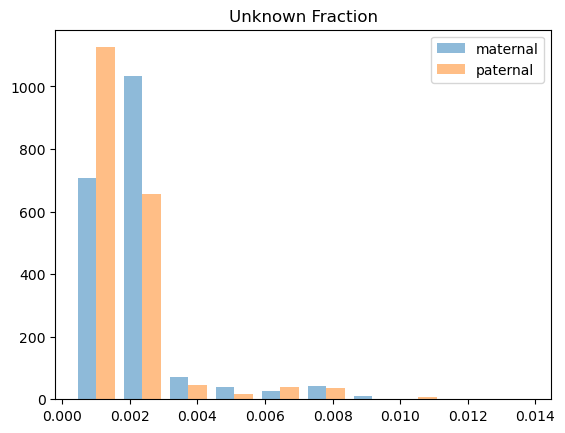

In [56]:
plt.hist([[x['maternal_unknown_fraction'] for x in sibpairs], 
          [x['paternal_unknown_fraction'] for x in sibpairs]], 
         alpha=0.5, label=['maternal', 'paternal'])
plt.title('Unknown Fraction')
plt.legend()
plt.show()

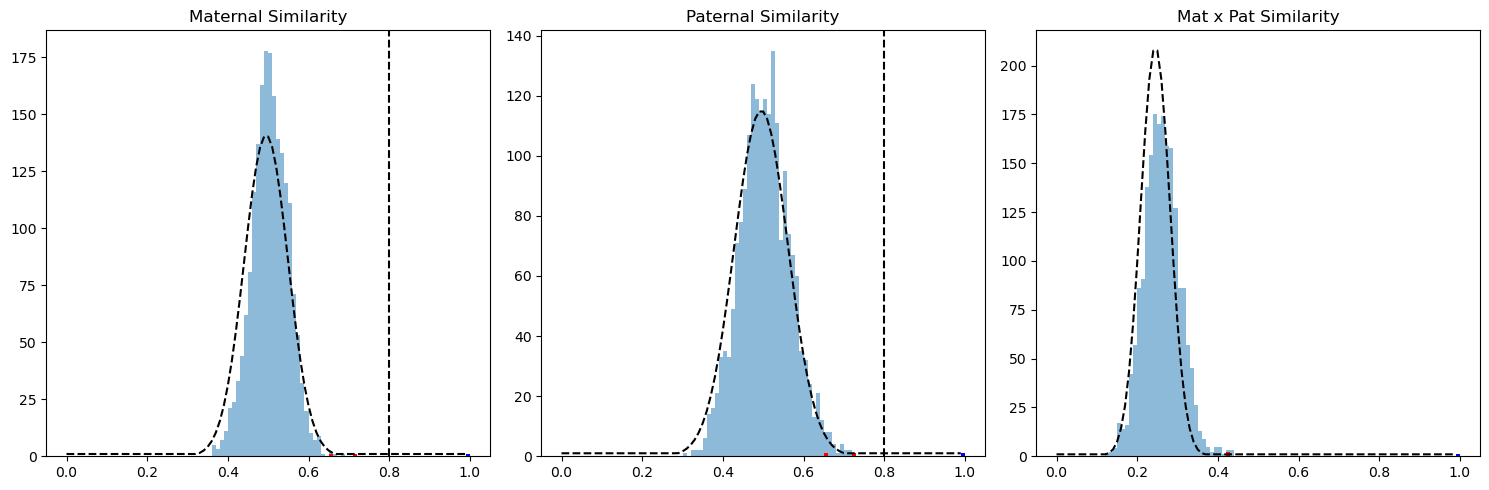

In [57]:
mat_scores = np.array([x['maternal_ibd'] for x in sibpairs])
pat_scores = np.array([x['paternal_ibd'] for x in sibpairs])
both_scores = np.array([x['matxpat_ibd'] for x in sibpairs])

bins = np.arange(0, 1.01, 0.01)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Maternal Similarity')
plt.hist(mat_scores, alpha=0.5, bins=bins)#, log=True)
plt.hist(mat_scores[is_outlier], color='red', bins=bins)#, log=True)
plt.hist(mat_scores[is_identical], color='blue', bins=bins)#, log=True)

p = 0.5
n = 2*42
model = stats.norm.cdf(bins[1:]*n, n*p, np.sqrt(n*p*(1-p)))-stats.norm.cdf(bins[:-1]*n, n*p, np.sqrt(n*p*(1-p)))
model = model/np.sum(model)
plt.plot(bins[:-1], np.clip(np.sum(~is_outlier)*model, 1, None), color='black', linestyle='--')

plt.axvline(0.8, color='black', linestyle='--')

plt.subplot(1, 3, 2)
plt.title('Paternal Similarity')
plt.hist(pat_scores, alpha=0.5, bins=bins)#, log=True)
plt.hist(pat_scores[is_outlier], color='red', bins=bins)#, log=True)
plt.hist(pat_scores[is_identical], color='blue', bins=bins)#, log=True)

n = 2*28
model = stats.norm.cdf(bins[1:]*n, n*p, np.sqrt(n*p*(1-p)))-stats.norm.cdf(bins[:-1]*n, n*p, np.sqrt(n*p*(1-p)))
model = model/np.sum(model)
plt.plot(bins[:-1], np.clip(np.sum(~is_outlier)*model, 1, None), color='black', linestyle='--')

plt.axvline(0.8, color='black', linestyle='--')

plt.subplot(1, 3, 3)
plt.title('Mat x Pat Similarity')
plt.hist(both_scores, alpha=0.5, bins=bins)#, log=True)
plt.hist(both_scores[is_outlier], color='red', bins=bins)#, log=True)
plt.hist(both_scores[is_identical], color='blue', bins=bins)#, log=True)

n = 2*28 + 2*42
p = 0.25
model = stats.norm.cdf(bins[1:]*n, n*p, np.sqrt(n*p*(1-p)))-stats.norm.cdf(bins[:-1]*n, n*p, np.sqrt(n*p*(1-p)))
model = model/np.sum(model)
plt.plot(bins[:-1], np.clip(np.sum(~is_outlier)*model, 1, None), color='black', linestyle='--')

plt.tight_layout()
plt.show()

[-0.18613343  0.0831876   0.35250863  0.62182967  0.8911507   1.16047174
  1.42979277  1.6991138   1.96843484  2.23775587  2.5070769 ] 3.032252663550419 -0.3257806543573544 0.10743849227125513


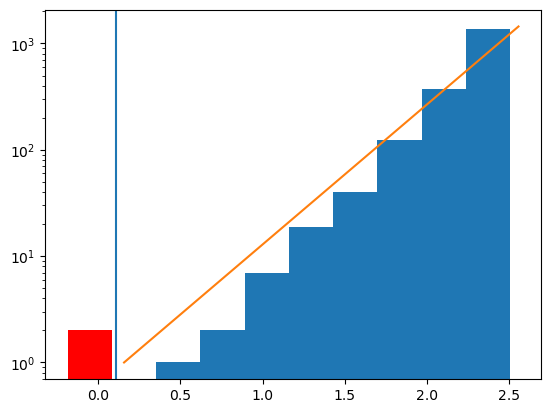

In [45]:
detector = OutlierDetector(mat_scores[~is_identical], pat_scores[~is_identical], 0.1)
scores = detector.score_samples(mat_scores, pat_scores)
outlier_cutoff, m, b = detector.outlier_cutoff, detector.m, detector.b
bins = detector.bins

plt.hist(scores, bins=bins, log=True)
plt.hist(scores[is_outlier], bins=bins, log=True, color='red')
plt.plot([outlier_cutoff+0.05, bins[-1]+0.05], [np.exp(m*outlier_cutoff+b), np.exp(m*bins[-1]+b)])
plt.axvline(outlier_cutoff)
plt.show()

In [46]:
xintervals = np.arange(x_min, x_max, 0.01)
yintervals = np.arange(y_min, y_max, 0.01)
gridx, gridy = np.meshgrid(xintervals, yintervals)
predict = detector.score_samples(gridx.flatten(), gridy.flatten())


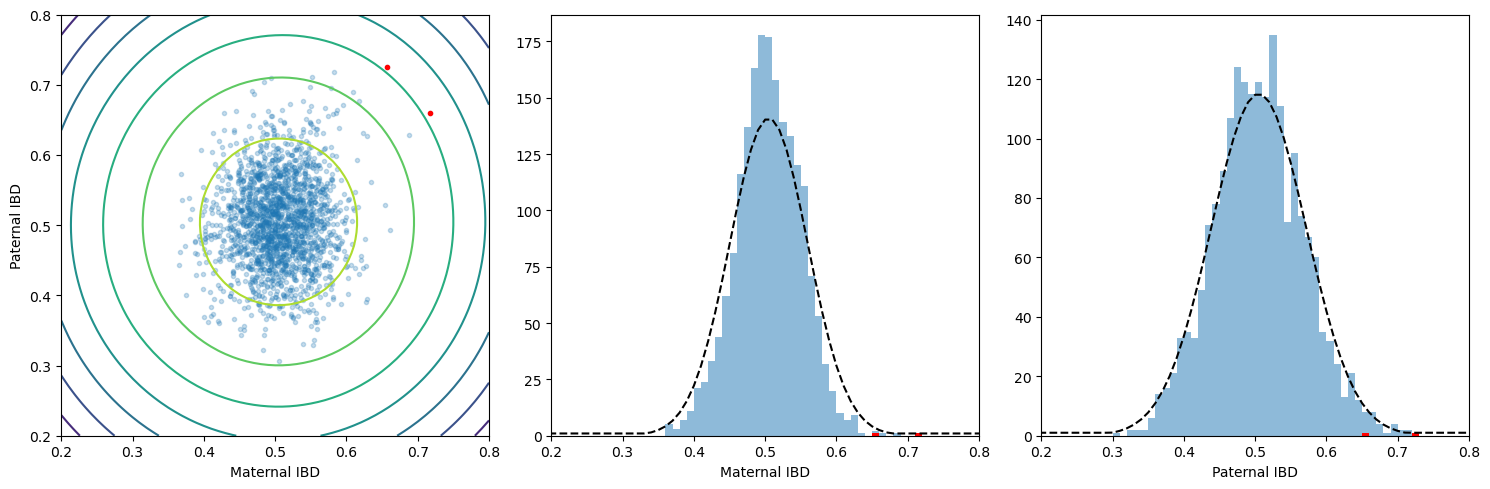

In [47]:
bins = np.arange(0, 1.01, 0.01)

# gaussian
#mean = np.mean(np.hstack((mat_crossovers[:, np.newaxis], pat_crossovers[:, np.newaxis])), axis=0)
#cov = np.cov(np.hstack((mat_crossovers[:, np.newaxis], pat_crossovers[:, np.newaxis])), rowvar=0)

#x, y = np.mgrid[40:150, 40:100]
#pos = np.dstack((x, y))
#rv = stats.multivariate_normal(mean, cov)
#plt.contour(x, y, rv.pdf(pos))

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.contour(xintervals, yintervals, predict.reshape(len(yintervals), len(xintervals)))
plt.scatter(mat_scores, pat_scores, marker='.', alpha=0.25)
plt.scatter(mat_scores[is_outlier], pat_scores[is_outlier], marker='.', color='red')
plt.scatter(mat_scores[is_identical], pat_scores[is_identical], marker='.', color='blue')
plt.xlabel('Maternal IBD')
plt.ylabel('Paternal IBD')
plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])

plt.subplot(1, 3, 2)
plt.hist(mat_scores, alpha=0.5, bins=bins, label='mat')
plt.hist(mat_scores[is_outlier], bins=bins, color='red')
plt.hist(mat_scores[is_identical], bins=bins, color='blue')

p = 0.5
n = 2*42
model = stats.norm.cdf(bins[1:]*n, n*p, np.sqrt(n*p*(1-p)))-stats.norm.cdf(bins[:-1]*n, n*p, np.sqrt(n*p*(1-p)))
model = model/np.sum(model)
plt.plot(bins[:-1]+0.01, np.clip(np.sum(~is_outlier)*model, 1, None), color='black', linestyle='--')
plt.xlabel('Maternal IBD')
plt.xlim([x_min, x_max])

plt.subplot(1, 3, 3)
plt.hist(pat_scores, alpha=0.5, bins=bins, label='pat')
plt.hist(pat_scores[is_outlier], bins=bins, color='red')
plt.hist(pat_scores[is_identical], bins=bins, color='blue')

p = 0.5
n = 2*28
model = stats.norm.cdf(bins[1:]*n, n*p, np.sqrt(n*p*(1-p)))-stats.norm.cdf(bins[:-1]*n, n*p, np.sqrt(n*p*(1-p)))
model = model/np.sum(model)
plt.plot(bins[:-1]+0.01, np.clip(np.sum(~is_outlier)*model, 1, None), color='black', linestyle='--')
plt.xlabel('Paternal IBD')
plt.xlim([y_min, y_max])

plt.tight_layout()
plt.show()

0.5049664387085094 0.002064910811409728 60.535302207392526
0.5050521216486644 0.003989962201139907 31.328617590484512


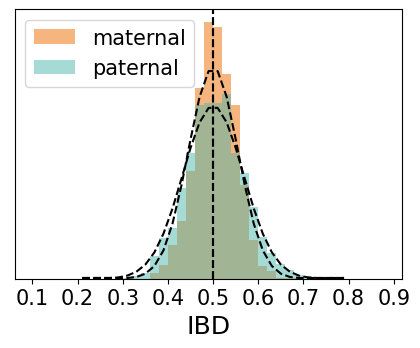

In [58]:
plt.figure(figsize=(5, 3.5))

m, s = np.mean(mat_scores[~is_outlier]), np.std(mat_scores[~is_outlier])
print(m, s**2, 0.125/(s**2))
plt.hist(mat_scores[~is_outlier], alpha=0.5, bins=np.arange(min(x_min, y_min)-0.1, max(x_max, y_max)+0.1, 0.02), label='maternal', color=colors[0])
plt.axvline(0.5, color='black', linestyle='--')
plt.xlabel('IBD')

#plt.legend()

bins = np.arange(0.2, 0.8, 0.02)

p = 0.5
n = 2*42
model = stats.norm.cdf(bins[1:]*n, n*p, np.sqrt(n*p*(1-p)))-stats.norm.cdf(bins[:-1]*n, n*p, np.sqrt(n*p*(1-p)))
model = model/np.sum(model)
plt.plot(bins[:-1]+0.01, np.clip(np.sum(~is_outlier)*model, 1, None), color='black', linestyle='--')

m, s = np.mean(pat_scores[~is_outlier]), np.std(pat_scores[~is_outlier])
print(m, s**2, 0.125/(s**2))
plt.hist(pat_scores[~is_outlier], alpha=0.5, bins=np.arange(min(x_min, y_min)-0.1, max(x_max, y_max)+0.1, 0.02), label='paternal', color=colors[1])
plt.axvline(0.5, color='black', linestyle='--')
plt.xlabel('IBD', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks([])
#plt.legend()

p = 0.5
n = 2*28
model = stats.norm.cdf(bins[1:]*n, n*p, np.sqrt(n*p*(1-p)))-stats.norm.cdf(bins[:-1]*n, n*p, np.sqrt(n*p*(1-p)))
model = model/np.sum(model)
plt.plot(bins[:-1]+0.01, np.clip(np.sum(~is_outlier)*model, 1, None), color='black', linestyle='--')
plt.legend(fontsize=15)

plt.savefig('../plots/ibd.png', bbox_inches="tight")



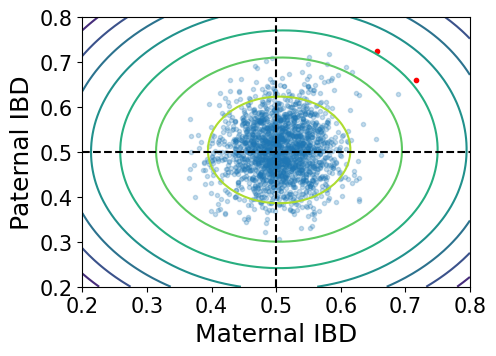

In [49]:
plt.figure(figsize=(5, 3.5))
#plt.subplot(1, 2, 1)
plt.contour(xintervals, yintervals, predict.reshape(len(yintervals), len(xintervals)))
plt.scatter(mat_scores, pat_scores, marker='.', alpha=0.25)
plt.scatter(mat_scores[is_outlier], pat_scores[is_outlier], marker='.', color='red')
plt.scatter(mat_scores[is_identical], pat_scores[is_identical], marker='.', color='blue')
plt.xlabel('Maternal IBD', fontsize=18)
plt.ylabel('Paternal IBD', fontsize=18)
plt.axvline(0.5, color='black', linestyle='--')
plt.axhline(0.5, color='black', linestyle='--')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])

plt.show()


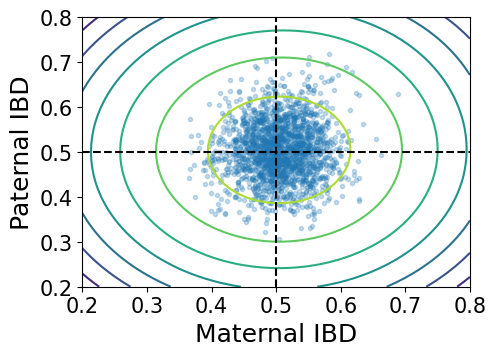

In [59]:
plt.figure(figsize=(5, 3.5))
#plt.subplot(1, 2, 1)
plt.contour(xintervals, yintervals, predict.reshape(len(yintervals), len(xintervals)))
plt.scatter(mat_scores[~is_outlier], pat_scores[~is_outlier], marker='.', alpha=0.25)
plt.xlabel('Maternal IBD', fontsize=18)
plt.ylabel('Paternal IBD', fontsize=18)
plt.axvline(0.5, color='black', linestyle='--')
plt.axhline(0.5, color='black', linestyle='--')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])

plt.savefig('../plots/Supplemental_Fig_S26.png', bbox_inches="tight")
